In [19]:
# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

# Computer Vision / Data imports
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Analysis & Metrics imports
from sklearn.metrics import confusion_matrix, classification_report

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Utility imports
import numpy as np
import time

In [20]:
train_loc = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/train'
val_loc = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/val'
test_loc = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/test'

In [21]:
# Colab Pro+ Optimizations
def setup_colab():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
    return device

In [22]:
# Define transforms for LeNet5 (32x32 images)
transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_eval = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [23]:
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [24]:
def train_lenet5():
    # Setup
    device = setup_colab()
    scaler = GradScaler()  # For mixed precision training

    # Load datasets with optimized settings
    train_dataset = ImageFolder(train_loc, transform=transform_train)
    val_dataset = ImageFolder(val_loc, transform=transform_eval)
    test_dataset = ImageFolder(test_loc, transform=transform_eval)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                            num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                           num_workers=2, pin_memory=True)

    # Initialize model and training components
    model = LeNet5(num_classes=len(train_dataset.classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Training loop
    num_epochs = 50
    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'epoch_times': []}

    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Start timing the epoch
        model.train()
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Use mixed precision training
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

            if (i + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Step [{i+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')

            # Clear cache periodically
            if i % 50 == 0:
                torch.cuda.empty_cache()

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate metrics
        epoch_time = time.time() - epoch_start_time  # Calculate epoch duration
        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total

        # Update history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)
        history['epoch_times'].append(epoch_time)

        print(f'Epoch [{epoch+1}/{num_epochs}]:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.2f}%')
        print(f'Epoch Time: {epoch_time:.2f} seconds')

        # Save best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
            }, 'best_lenet5.pth')

        scheduler.step()

    return model, history, best_val_acc

In [25]:
def plot_confusion_matrix(all_labels, all_predictions, class_names, accuracy):
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Create figure
    plt.figure(figsize=(20, 8))

    # Plot confusion matrix
    plt.subplot(121)
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)

    plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}%')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Plot class accuracies
    plt.subplot(122)
    class_accuracy = (cm.diagonal() / cm.sum(axis=1)) * 100

    # Create bar plot
    bars = plt.bar(range(len(class_names)), class_accuracy)

    # Add percentage labels on top of bars
    for idx, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')

    plt.title('Per-Class Accuracy')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
    plt.ylim(0, 100)

    plt.tight_layout()
    return plt.gcf()

In [26]:
def test_model(model_path, test_loc, model_name):
    # Load the best model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model
    model = LeNet5(num_classes=30)

    # Load the saved state
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    # Data transformation for testing
    transform_test = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load test dataset
    test_dataset = ImageFolder(test_loc, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    all_predictions = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        with autocast():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total

    # Get class names
    class_names = test_dataset.classes

    # Create visualization
    fig = plot_confusion_matrix(all_labels, all_predictions, class_names, accuracy)

    # Get classification report
    report = classification_report(all_labels, all_predictions, target_names=class_names)

    print(f"\nTest Accuracy: {accuracy:.2f}%")
    print("\nClassification Report:")
    print(report)

    return accuracy, confusion_matrix(all_labels, all_predictions), report

<ipython-input-24-beae8e5e1209>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision training
<ipython-input-24-beae8e5e1209>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/50], Step [10/657], Loss: 3.4006
Epoch [1/50], Step [20/657], Loss: 3.4109
Epoch [1/50], Step [30/657], Loss: 3.3790
Epoch [1/50], Step [40/657], Loss: 3.4084
Epoch [1/50], Step [50/657], Loss: 3.4138
Epoch [1/50], Step [60/657], Loss: 3.4005
Epoch [1/50], Step [70/657], Loss: 3.4001
Epoch [1/50], Step [80/657], Loss: 2.9673
Epoch [1/50], Step [90/657], Loss: 3.0810
Epoch [1/50], Step [100/657], Loss: 3.1606
Epoch [1/50], Step [110/657], Loss: 2.9377
Epoch [1/50], Step [120/657], Loss: 2.9518
Epoch [1/50], Step [130/657], Loss: 2.9642
Epoch [1/50], Step [140/657], Loss: 2.8736
Epoch [1/50], Step [150/657], Loss: 3.3403
Epoch [1/50], Step [160/657], Loss: 2.7599
Epoch [1/50], Step [170/657], Loss: 2.7935
Epoch [1/50], Step [180/657], Loss: 3.0862
Epoch [1/50], Step [190/657], Loss: 2.8910
Epoch [1/50], Step [200/657], Loss: 2.9116
Epoch [1/50], Step [210/657], Loss: 2.9211
Epoch [1/50], Step [220/657], Loss: 2.7956
Epoch [1/50], Step [230/657], Loss: 2.9588
Epoch [1/50], Step [

<ipython-input-24-beae8e5e1209>:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/50]:
Training Loss: 2.8434
Validation Loss: 2.5433
Validation Accuracy: 25.02%
Epoch Time: 2478.00 seconds
Epoch [2/50], Step [10/657], Loss: 2.7914
Epoch [2/50], Step [20/657], Loss: 2.4243
Epoch [2/50], Step [30/657], Loss: 3.0435
Epoch [2/50], Step [40/657], Loss: 2.6992
Epoch [2/50], Step [50/657], Loss: 2.4852
Epoch [2/50], Step [60/657], Loss: 2.8784
Epoch [2/50], Step [70/657], Loss: 2.4990
Epoch [2/50], Step [80/657], Loss: 2.3358
Epoch [2/50], Step [90/657], Loss: 2.6780
Epoch [2/50], Step [100/657], Loss: 2.4530
Epoch [2/50], Step [110/657], Loss: 2.4009
Epoch [2/50], Step [120/657], Loss: 2.4851
Epoch [2/50], Step [130/657], Loss: 2.8190
Epoch [2/50], Step [140/657], Loss: 2.4683
Epoch [2/50], Step [150/657], Loss: 2.4639
Epoch [2/50], Step [160/657], Loss: 2.5992
Epoch [2/50], Step [170/657], Loss: 2.4939
Epoch [2/50], Step [180/657], Loss: 2.7054
Epoch [2/50], Step [190/657], Loss: 2.3252
Epoch [2/50], Step [200/657], Loss: 2.5233
Epoch [2/50], Step [210/657], Los

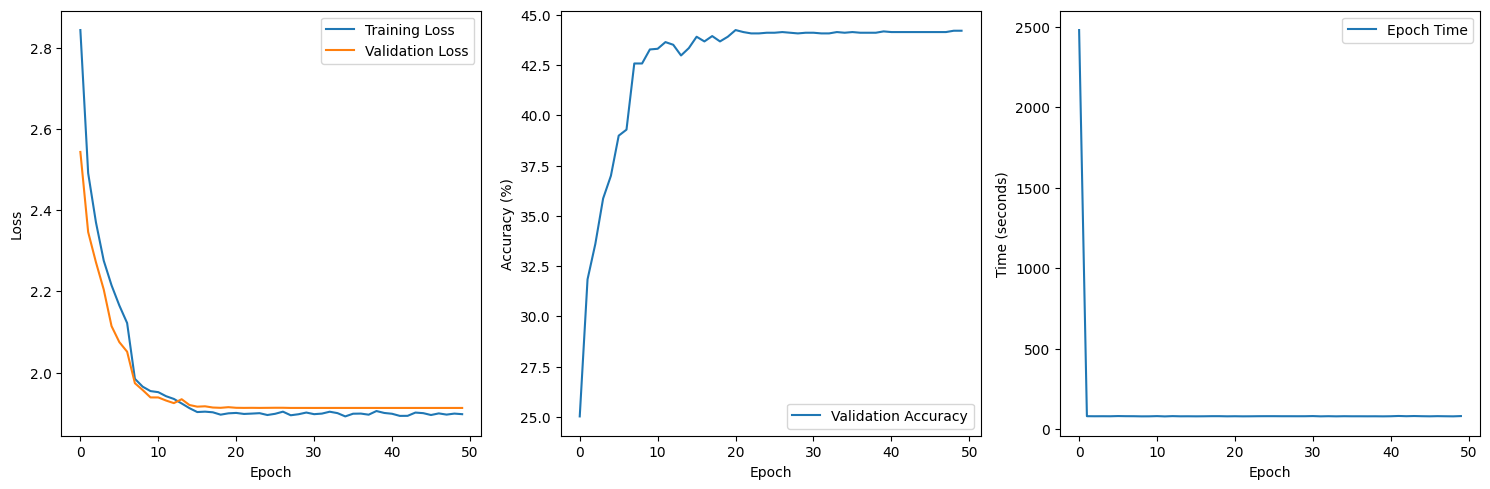

Best Validation Accuracy: 44.24%


In [28]:
if __name__ == '__main__':
    model, history, best_acc = train_lenet5()

    plt.figure(figsize=(15, 5))

    # Plot training and validation loss
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Plot epoch times
    plt.subplot(1, 3, 3)
    plt.plot(history['epoch_times'], label='Epoch Time')
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f'Best Validation Accuracy: {best_acc:.2f}%')


Testing the best model...


<ipython-input-16-52919ba1cd08>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
<ipython-input-16-52919ba1cd08>:31: FutureWarning: `torc


Test Accuracy: 42.82%

Classification Report:
               precision    recall  f1-score   support

     aloevera       0.49      0.43      0.46       200
       banana       0.25      0.28      0.26       200
      bilimbi       0.10      0.10      0.10       200
   cantaloupe       0.37      0.07      0.12       200
      cassava       0.42      0.54      0.47       200
      coconut       0.32      0.34      0.33       200
         corn       0.35      0.39      0.36       200
     cucumber       0.36      0.44      0.39       200
      curcuma       0.46      0.62      0.53       200
     eggplant       0.63      0.68      0.65       200
     galangal       0.44      0.42      0.43       200
       ginger       0.33      0.55      0.41       200
        guava       0.56      0.44      0.49       200
         kale       0.39      0.24      0.30       200
    longbeans       0.43      0.23      0.30       200
        mango       0.33      0.14      0.20       200
        melon    

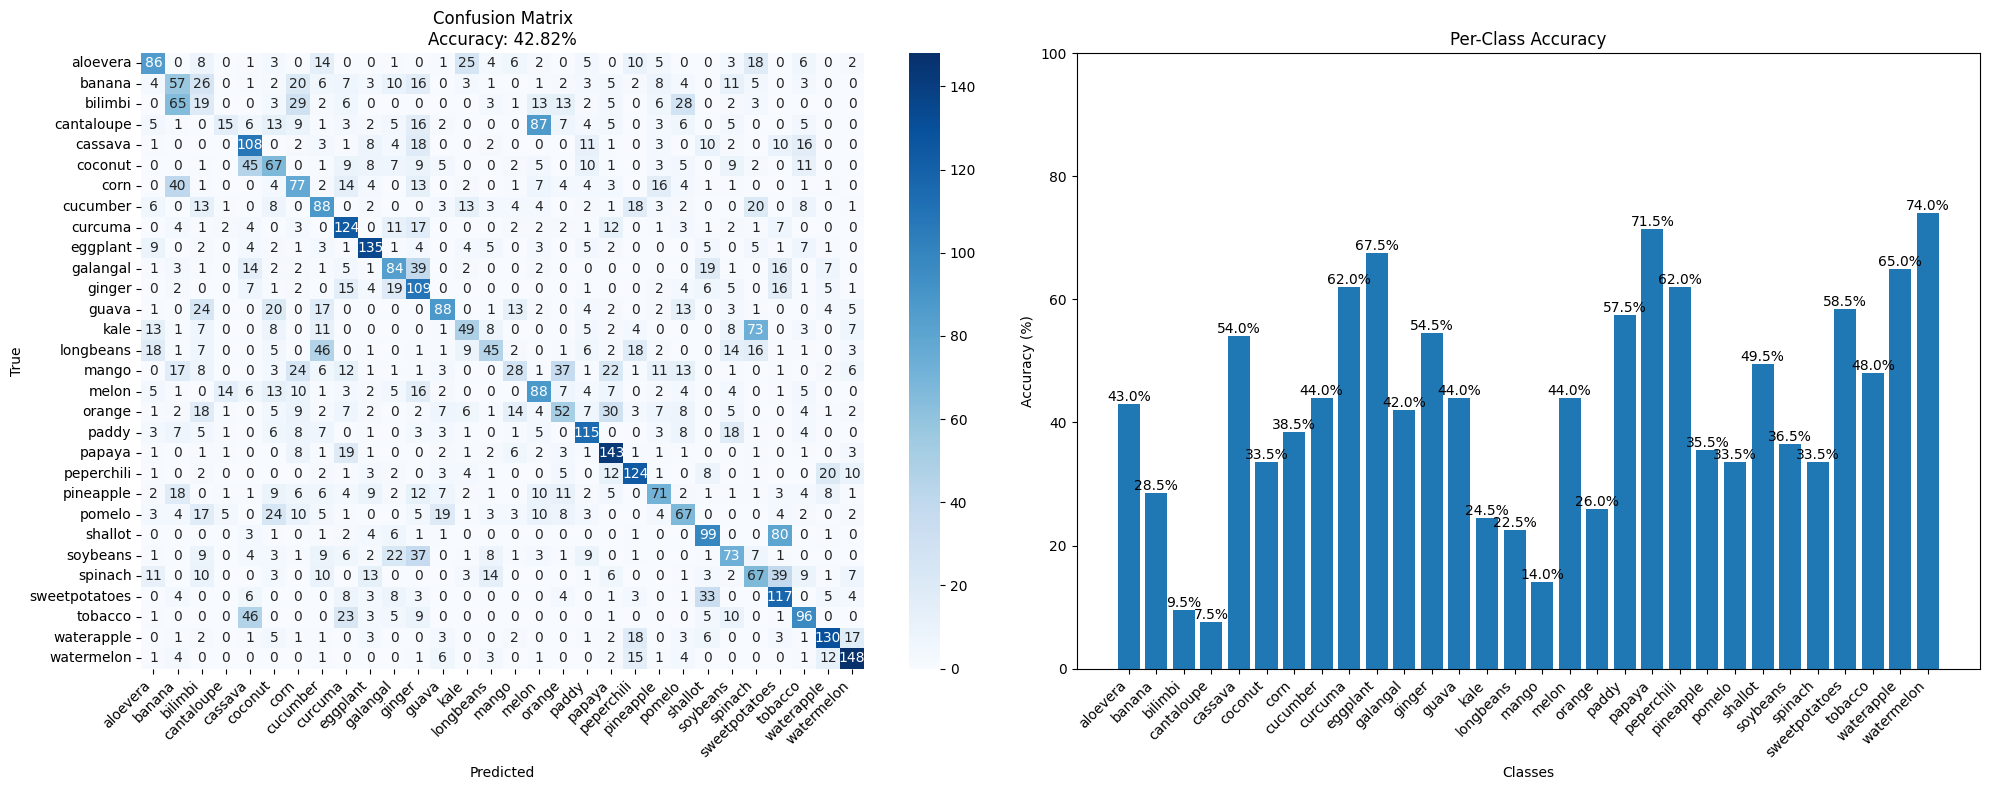

In [ ]:
print("\nTesting the best model...")
model_path = "/content/drive/MyDrive/Colab Notebooks/Capstone Project/best_lenet5.pth"
accuracy, confusion_mat, report = test_model(model_path, test_loc, LeNet5)